# Load Dependencies

In [11]:
import pandas as pd
from rdkit import Chem
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
random_seed=2022

# Load Data

In [3]:
df_data=pd.read_excel('./Data/Data.xlsx')
train_num=49
re_1=np.array(df_data)[:train_num,1]
re_2=np.array(df_data)[:train_num,2]
set1=np.array(df_data)[:train_num,3]
set2=np.array(df_data)[:train_num,4]
ratio=np.array(df_data)[:train_num,8]
des_all=np.array(df_data)[:train_num,9:]
ratio_log=np.array([np.log(i) for i in ratio])
des_max=des_all[:train_num,:].max(axis=0)
des_min=des_all[:train_num,:].min(axis=0)
des_all_std=(des_all-des_min)/(des_max-des_min)
smiles_set_map_df = pd.read_csv('./Data/re_1_smiles_set_dict.csv')
smiles_set_map={str(smi):[a,b,c,d] for smi,a,b,c,d in zip(smiles_set_map_df['SMILES'].to_list(),
                                              smiles_set_map_df['1'].to_list(),smiles_set_map_df['2'].to_list(),
                                              smiles_set_map_df['3'].to_list(),smiles_set_map_df['4'].to_list())} 
re_1_set=set(re_1)

,Unnamed: 0,reactant1,reactant2,set1,set2,n(r1)/n(r2),elecricity,T,ratio,8,...,25,26,27,28,29,30,31,32,33,34
0,0,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,2.100000,1.702967,...,0.188588,0.674357,0.677398,0.969871,0.971426,1.081074,1.080450,-0.389886,-0.216763,2.479014
1,1,CC1=CC=CC=C1,C=CC(OCCCC)=O,0,2,10,1,60,1.909091,1.702967,...,0.189256,0.674357,0.677407,0.969871,0.971746,1.081074,1.080049,-0.389886,-0.216763,2.479014
2,2,CC1=CC=CC=C1,C=CC(OCCCC)=O,1,2,10,1,60,0.909091,1.703407,...,0.189256,0.677398,0.677407,0.971426,0.971746,1.080450,1.080049,-0.389886,-0.216763,2.479014
3,3,C12=CC=CC=C1C=CC=C2,C=CC(OCCCC)=O,0,1,5,1,60,2.800000,1.700055,...,0.189094,0.663741,0.666087,0.968543,0.971183,1.081061,1.080405,-0.377368,-0.257932,1.927644
4,4,ClC1=C(OC)C=CC=C1,C=CC(OCCCC)=O,0,1,10,1,60,0.625000,1.808682,...,0.189501,0.645294,0.665523,0.964724,0.970356,1.078336,1.079508,-0.382940,-0.236381,2.087947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,178,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,0,2,5,1,60,NaN,1.716123,...,0.191708,0.647493,0.647493,0.966527,0.966527,1.078416,1.078416,-0.403884,-0.249023,2.647464
172,179,CC1=C(Cl)C=CC=C1Cl,C=CC(OCCCC)=O,1,2,5,1,60,NaN,1.732552,...,0.191708,0.649563,0.647493,0.967510,0.966527,1.078610,1.078416,-0.403884,-0.249023,2.647464
173,183,CC1=CC(C(C)(C)C)=CC(C(C)(C)C)=C1,C=CC(OCCCC)=O,0,1,5,1,60,NaN,3.247917,...,0.186582,0.659148,0.665309,0.959024,0.964251,1.076515,1.078161,-0.376850,-0.206119,2.135690
174,184,OCC1=CC=CC=C1CO,C=CC(OCCCC)=O,0,1,5,1,60,NaN,1.789384,...,0.188802,0.680891,16.434056,0.964429,0.970808,1.078049,1.079957,-0.390885,-0.225707,2.425742


# OOS Prediction

In [5]:
e=2.718281828459
pred_value=[]
exp_value=[]
smi2=[]
pred_value2=[]
exp_value2=[]
smi3=[]
pred_value3=[]
exp_value3=[]
mul_smi=[]
pred_valuemul=[]
exp_valuemul=[]

for tem_re_1 in re_1_set:

    train_index=[]
    test_index=[]
    test_detail=[]
    for index,tem_re1 in enumerate(re_1):
        if tem_re1==tem_re_1:
            test_index.append(index)
            test_detail.append([set1[index],set2[index]])
        else:
            train_index.append(index)

    sel_index = [9, 11, 5, 25, 26, 18, 17, 16, 21, 15, 13, 24, 8, 19, 2]
    des_sel=des_all_std[:train_num,sel_index]
    model =  ExtraTreesRegressor(random_state=random_seed,n_jobs=60)
    all_r2 = []
    all_pearsr = []
    all_mae = []
    repeat_pred = []
    repeat_test = []
    for i in range(50):
        train_x,test_x = des_sel[train_index],des_sel[test_index]
        train_y,test_y = ratio_log[train_index],ratio_log[test_index] 
        model.fit(train_x,train_y)
        test_pred = model.predict(test_x)
        repeat_pred.append(test_pred)
        repeat_test.append(test_y)
    repeat_pred=np.mean(np.array(repeat_pred),axis=0)   
    repeat_test=np.mean(np.array(repeat_test),axis=0) 
    pred_value.append(np.round((repeat_pred),3))
    exp_value.append(np.round(repeat_test,3))
    tem_test=np.round(e**repeat_test,3)
    tem_pred=np.round((e**repeat_pred),3)

    print('molecule: ',tem_re_1,'\n',
          '  site:  ',test_detail,'\n',
          '  exp.:  ',tem_test,'\n',
          '  pred.:  ',tem_pred,'\n')
    if len(test_detail)==1:
        pred_value2.append(tem_pred)
        exp_value2.append(tem_test)  
        smi2.append(tem_re_1)
    elif len(test_detail)==3:
        pred_value3.append(tem_pred)
        exp_value3.append(tem_test)
        smi3.append(tem_re_1)
    else:
        pred_valuemul.append(tem_pred)
        exp_valuemul.append(tem_test)
        mul_smi.append(tem_re_1)

molecule  COC1=CC=CC=C1 
   site   [[0, 2]] 
   exp.   [16.] 
   pred.   [14.199] 

molecule  C1(CCCC2)=C2C=CC=C1 
   site   [[0, 1]] 
   exp.   [0.714] 
   pred.   [0.735] 

molecule  OC1=CC=CC=C1 
   site   [[0, 2]] 
   exp.   [3.2] 
   pred.   [6.894] 

molecule  C12=CC=CC=C1OCO2 
   site   [[0, 1]] 
   exp.   [1.9] 
   pred.   [3.973] 

molecule  CCOC1=CC=CC=C1 
   site   [[0, 2]] 
   exp.   [20.] 
   pred.   [18.789] 

molecule  ClC1=CC=C(OC)C=C1 
   site   [[0, 1]] 
   exp.   [7.6] 
   pred.   [3.697] 

molecule  CC([Si](OC1=CC=CC=C1)(C(C)C)C(C)C)C 
   site   [[0, 2]] 
   exp.   [1.] 
   pred.   [1.475] 

molecule  FC1=CC=C(OC)C=C1 
   site   [[0, 1]] 
   exp.   [3.6] 
   pred.   [1.164] 

molecule  C12=CC=CC=C1C=CO2 
   site   [[0, 1]] 
   exp.   [2.3] 
   pred.   [1.735] 

molecule  CC1=CC=CC=C1 
   site   [[0, 1], [0, 2], [1, 2]] 
   exp.   [2.1   1.909 0.909] 
   pred.   [1.716 1.182 0.802] 

molecule  CC1=CC=CS1 
   site   [[0, 2]] 
   exp.   [5.8] 
   pred.   [3.037] 

mole

# Results

## Two Sites

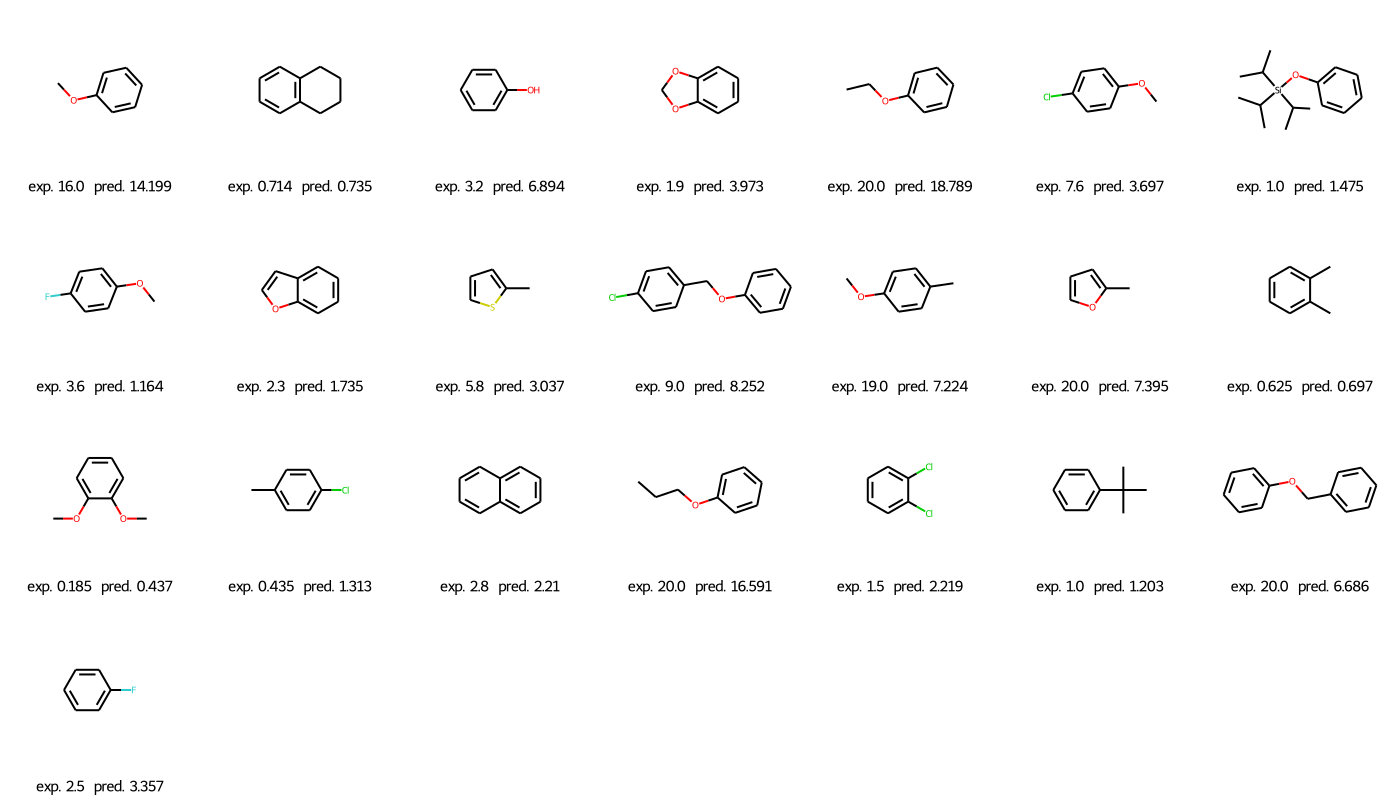

<Figure size 6000x5000 with 0 Axes>

In [6]:
mol2=[]
for index,i in enumerate(smi2):
     mol2.append(Chem.MolFromSmiles(i))
        
fig = plt.figure(figsize=(60,50))
Chem.Draw.MolsToGridImage(mol2,molsPerRow=7,subImgSize=(200,200),
                          legends=['exp. '+str(tem_exp[0])+'  pred. '+str(tem_pred[0]) for tem_exp,tem_pred in zip(exp_value2,pred_value2)])

## Three Sites

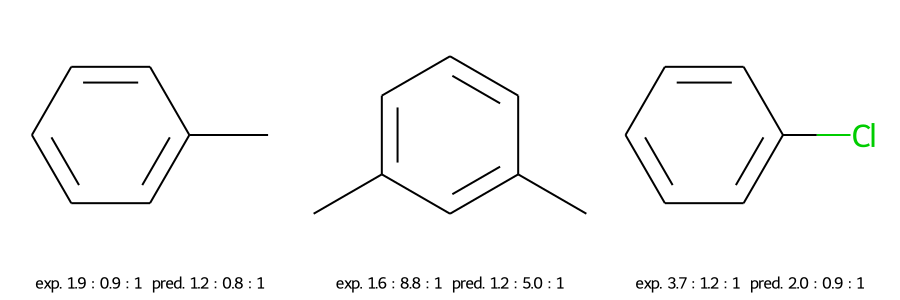

<Figure size 6000x5000 with 0 Axes>

In [8]:
mol3=[]
for index,i in enumerate(smi3):
     mol3.append(Chem.MolFromSmiles(i))
        
fig = plt.figure(figsize=(60,50))
Chem.Draw.MolsToGridImage(mol3,molsPerRow=3,subImgSize=(300,300),
                          legends=['exp. '+str(tem_exp[1])+str(' : ')+str(tem_exp[2])+str(' : ')+str(1)+'  pred. '+str(tem_pred[1])+str(' : ')+str(tem_pred[2])+str(' : ')+str(1) for tem_exp,tem_pred in zip(np.round(exp_value3,1),np.round(pred_value3,1))])